[SIFT](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) (Scale Invariant Feature Transform)

- Helps with rotation and scale in different images, as well as occlusion from other objects.
- Keypoints - detect blobs at different scales.
- Blobs have a center, a size, and an orientation.

**In animal feature extraction:**

- Tharwat1 et. al, A Fully-Automated Zebra Animal Identification
Approach Based on SIFT Features: SIFT, followed by PCA and SVM.
- 1. Create a Difference of Gaussians, by filtering the original image with Gaussian functions of many different scales and calculate the difference of Gaussian or the difference between two nearby scales separated by a constant multiplicative factor k as follows,follows, D(x, y, σ) =
L(x, y, kσ) − L(x, y, σ), where L(x, y, σ) and L(x, y, kσ), are two images that
produced from the convolution of Gaussian functions with an input image I(x, y)
using σ and kσ, respectively, as follows, L(x, y, σ) = G(x, y, σ) ∗ I(x, y), where the Gaussian function is denoted by G(x, y, σ) = 1 / 2πσ2 exp[−x2+y2 / σ2].
- 2. Next, find **keypoints** by comparing each point with the pixels of all its 26 neighbours to compute the extrema point. However, some keypoints represent noise which needs to be eliminated by finding those that have low contrast or are poorly localized on an edge. One or more orientations is assigned to the keypoints based on local image properties. An orientation histogram is formed from the gradient orientations of the sample points within a region around the keypoint.
- 3. The final step in SIFT is to create descriptions for the patch that is compact, highly distinctive and to be robust to changes in illumination and camera viewpoint. The image gradient magnitudes and orientations are sampled around the keypoint location and illustrated with small arrows at each sample location. (HOG???)

Rachel's recommendation:
- Try [Bag of Visual Words](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb) before SIFT

##Set Up

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors
from skimage.data import camera
from skimage.transform import rotate
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  18184      0 --:--:-- --:--:-- --:--:-- 18212
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gcsfuse is already the newest version (2.3.2).
0 upgraded, 0 newly inst

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"
downsampled_path = f"{local_path}/raw-data/downsampled-data"
preprocessed_path = f"{local_path}/raw-data/preprocessed_data"
preprocessed_red_path = f"{local_path}/raw-data/preprocessed_data_red"
low_res_path = f"{local_path}/raw-data/low_resolution_images"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721685213,"nanos":913796424},"severity":"INFO","message":"Start gcsfuse/2.3.2 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721685213,"nanos":914454078},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [ ]:
#check mounting
os.listdir(f"{local_path}/raw-data/")

['downsampled-data',
 'low_resolution_images',
 'orinoquia-camera-traps',
 'preprocessed_data',
 'preprocessed_data_red',
 'test_data',
 'train_data',
 'validation_data']

##Sample Image Per Class

- Try again with low resolution (currently only 10 images!)

In [ ]:
#check number of images: 31836
imageFilenames = pd.DataFrame(os.listdir(preprocessed_path), columns=['filename_new'])
imageFilenames['filename'] = imageFilenames['filename_new'].str.split('_').str[0]+'/'+imageFilenames['filename_new'].str.split('_').str[2]
numImage = len(imageFilenames)
print("Number of Images: ", numImage)
imageFilenames.head(5)

Number of Images:  31836


,filename_new,filename
0,A06_100EK113_01130049.JPG,A06/01130049.JPG
1,A06_100EK113_01130050.JPG,A06/01130050.JPG
2,A06_100EK113_01130051.JPG,A06/01130051.JPG
3,A06_100EK113_01130052.JPG,A06/01130052.JPG
4,A06_100EK113_01130053.JPG,A06/01130053.JPG


In [ ]:
# check number of images in low_res_path
numImage = len(os.listdir(low_res_path))
print("Number of Images: ", numImage)

Number of Images:  10


In [ ]:
#check data class distribution
imageLabels = pd.read_csv("/content/drive/MyDrive/w281_Project/0_data/sample_images/images_labels.csv")
imageLabels.head(5)

,filename,timestamp,image_id,common_name,sp_num
0,N25/03310082.JPG,2020-03-31T14:28:14Z,902b671f-58b9-4cb0-9898-bd53c9909e51,Collared Peccary,1
1,N29/03310288.JPG,2020-03-31T06:49:17Z,e727dc42-5ebb-46a0-a979-eac158c050e6,Collared Peccary,1
2,A06/06020479.JPG,2020-06-02T08:12:17Z,db3c3213-5ad9-4bf7-94a8-92ded5efb5a5,Black Agouti,1
3,A02/03100387.JPG,2020-03-10T06:58:27Z,c7e33138-08ac-461d-a267-ba44a2f123ad,Unknown species,1
4,A04/04180034.JPG,2020-04-18T05:37:56Z,52f77e0c-7023-4087-8414-26848579d14f,Bos Species,1


In [ ]:
#join for labels
df = imageFilenames.merge(imageLabels, on='filename', how='left')
df.head(5)

,filename_new,filename,timestamp,image_id,common_name,sp_num
0,A06_100EK113_01130049.JPG,A06/01130049.JPG,2020-01-13T19:34:24Z,082a4f9f-4888-478f-8db1-dc49530fd898,Dasypus Species,1
1,A06_100EK113_01130050.JPG,A06/01130050.JPG,2020-01-13T19:34:25Z,cdf8eb07-2165-477c-821b-b831bb937b93,Dasypus Species,1
2,A06_100EK113_01130051.JPG,A06/01130051.JPG,2020-01-13T19:34:26Z,d91e29f5-0787-435f-a7f2-e7adeaf09773,Dasypus Species,1
3,A06_100EK113_01130052.JPG,A06/01130052.JPG,2020-01-13T19:34:28Z,ad260c3b-530e-40d5-8ca0-4fd78276413e,Dasypus Species,1
4,A06_100EK113_01130053.JPG,A06/01130053.JPG,2020-01-13T19:34:29Z,d4fe1eaf-858c-406f-ae23-4c3973c41664,Dasypus Species,1


In [ ]:
#select image sample per class

species_list = ['Collared Peccary',
                'Spotted Paca',
                'Dasypus Species',
                'Domestic Horse',
                'Bos Species']

sample_filenames = []

for item in species_list:
  sample_filenames.append(df[df['common_name']==item].sample()['filename_new'].values[0])

In [ ]:
sample_filenames

['N29_105EK113_04100860.JPG',
 'N29_108EK113_07160667.JPG',
 'N25_102EK113_05160855.JPG',
 'A07_101EK113_05090436.JPG',
 'A07_102EK113_06300697.JPG']

##Feature - SIFT - skimage.feature

[Hyperparameters](https://github.com/scikit-image/scikit-image/blob/v0.24.0/skimage/feature/sift.py#L233-L274)


|Hyperparameter|Value|ValueError|
|---|---|---|
|upsampling|4|math domain error|

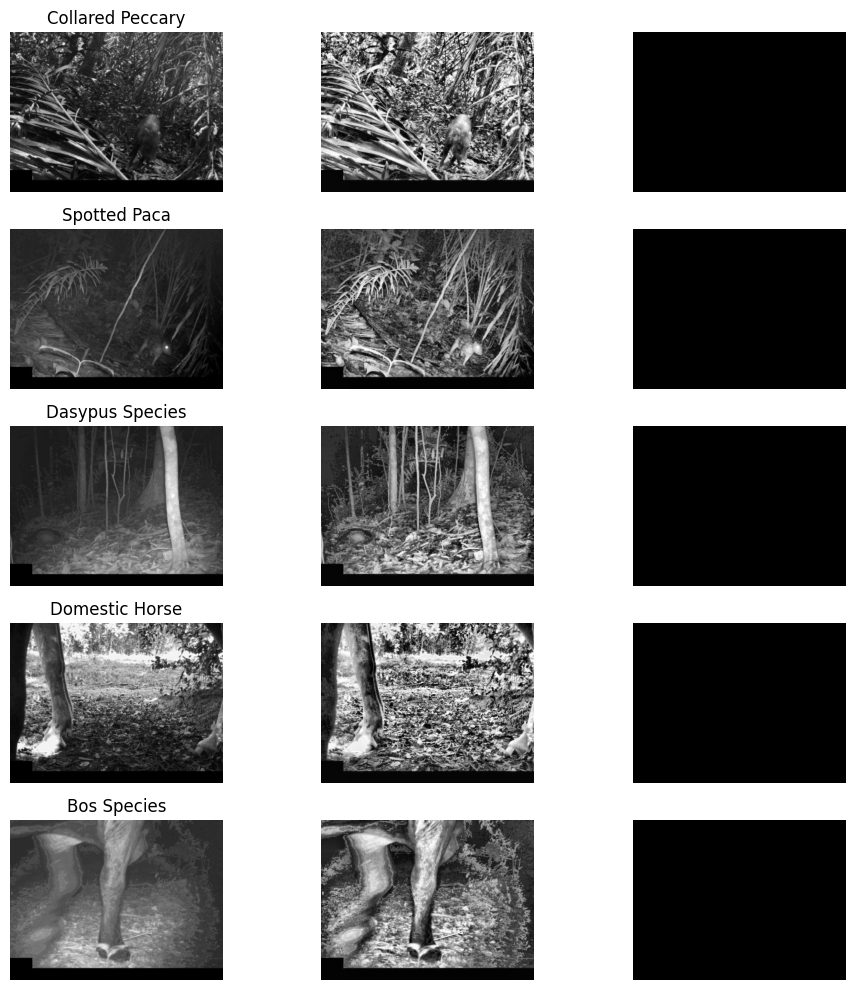

In [ ]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=3, figsize=(10, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  # img_raw = plt.imread(f"{downsampled_path}/{sample_filenames[i]}")
  # img_preprocessed = plt.imread(f"{preprocessed_path}/{sample_filenames[i]}")
  img_red = plt.imread(f"{preprocessed_red_path}/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.2, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)

  # SIFT
  #__init__(upsampling=2, n_octaves=8, n_scales=3, sigma_min=1.6,
  #         sigma_in=0.5, c_dog=0.013333333333333334, c_edge=10,
  #         n_bins=36, lambda_ori=1.5, c_max=0.8, lambda_descr=6,
  #         n_hist=4, n_ori=8)

  sift = SIFT(upsampling=1, n_octaves=15, c_dog=0.001, sigma_min=2.0, n_ori=64)
  keypoints = sift.detect(img_cl)
  if keypoints is not None:
      keypoints_xy = np.array([[kp.x, kp.y] for kp in keypoints])
      descriptors = sift.describe(img_cl, keypoints)
      # Draw keypoints
      img_sift = cv2.drawKeypoints(img_cl, keypoints_xy, img_cl, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      img_sift = cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB)
  else:
      # No keypoints were detected, so use a blank image
      img_sift = np.zeros_like(img_cl)*255


  # preprocessed and resized
  axs[i, 0].imshow(img_resized, cmap='gray')
  axs[i, 0].set_title(species_list[i])
  axs[i, 0].axis("off")

  #histogram equalization (CLAHE)
  axs[i, 1].imshow(img_cl, cmap='gray')
  axs[i, 1].axis("off")

  #SIFT
  axs[i, 2].imshow(img_sift, cmap='gray')
  axs[i, 2].axis("off")

plt.show()

## SIFT - using cv2

- Add bag of visual words: look at example paper. Can be very computationally expensive, so start of with very low resolution. (i.e 100). Looking for frequent types of features. Library of most common visual features.  
- SIFT alone: no apples to apples for how many or where you found them. Make sure that our feature vector compares the same thing.
- Positional feature vector - find a way to turn into a histogram.

- BRIEF is also fast, but lower quality.

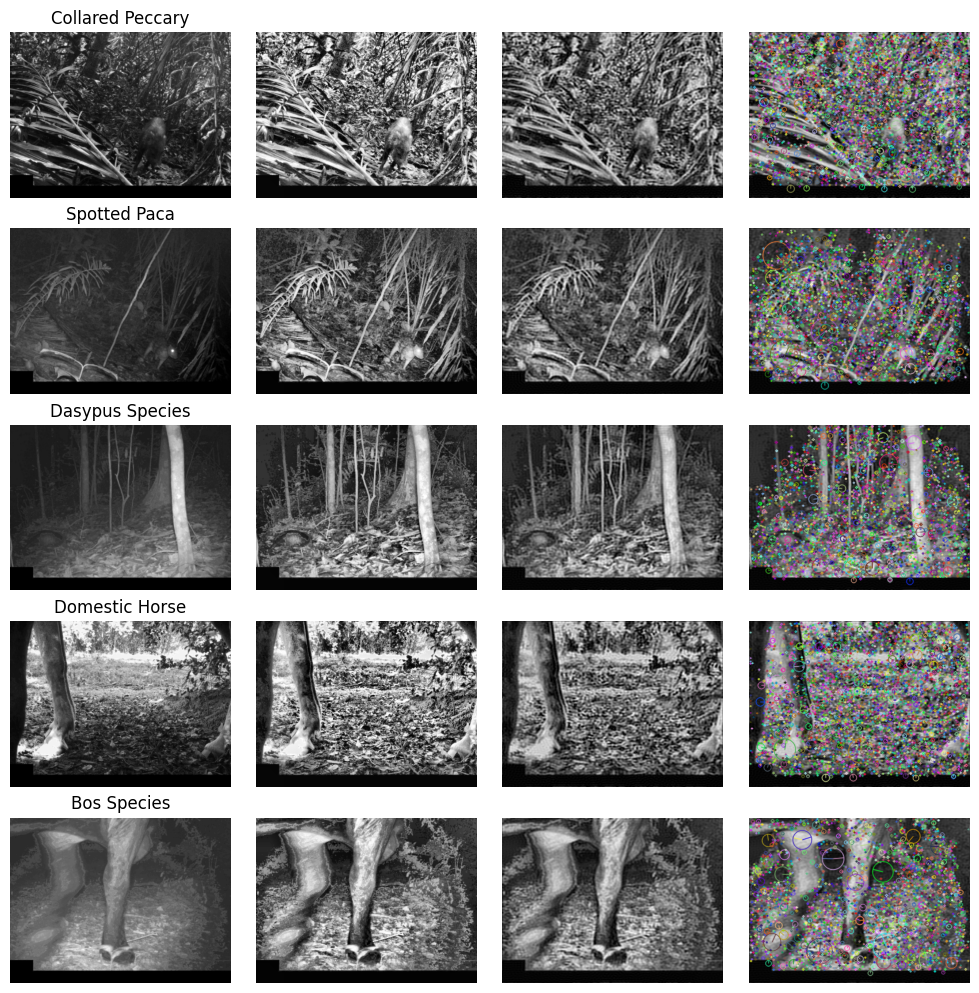

In [ ]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=4, figsize=(10, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  # img_raw = plt.imread(f"{downsampled_path}/{sample_filenames[i]}")
  # img_preprocessed = plt.imread(f"{preprocessed_path}/{sample_filenames[i]}")
  img_red = plt.imread(f"{preprocessed_red_path}/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.2, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)


  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)


  # Use Fourier to blur background, based on high frequencies:
  dft = cv2.dft(np.float32(img_cl), flags=cv2.DFT_COMPLEX_OUTPUT)

  # Shift the zero-frequency component to the center
  dft_shift = np.fft.fftshift(dft)

  # Create a low-pass filter (circular mask)
  rows, cols = img_cl.shape
  crow, ccol = rows // 2, cols // 2
  radius = int(min(crow, ccol) * 0.5)
  mask = np.zeros((rows, cols), dtype=np.uint8)
  cv2.circle(mask, (ccol, crow), radius, 1, -1)

  # Apply the low-pass filter
  real_part = dft_shift[:, :, 0] * mask
  imag_part = dft_shift[:, :, 1] * mask
  filtered_dft = np.stack((real_part, imag_part), axis=-1)

  # Shift the zero-frequency component back to the corner
  filtered_dft_ishift = np.fft.ifftshift(filtered_dft)

  # Apply Inverse Discrete Fourier Transform
  result = cv2.idft(filtered_dft_ishift)
  result = cv2.magnitude(result[:, :, 0], result[:, :, 1])

  fourierized = cv2.normalize(result, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  #sift
  sift = cv2.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(fourierized, None)
  sift_img = cv2.drawKeypoints(fourierized, keypoints, fourierized, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


  # preprocessed and resized
  axs[i, 0].imshow(img_resized, cmap='gray')
  axs[i, 0].set_title(species_list[i])
  axs[i, 0].axis("off")

  #histogram equalization (CLAHE)
  axs[i, 1].imshow(img_cl, cmap='gray')
  axs[i, 1].axis("off")

  #Fourier
  axs[i, 2].imshow(fourierized, cmap='gray')
  axs[i, 2].axis("off")

  #SIFT
  axs[i, 3].imshow(sift_img, cmap='gray')
  axs[i, 3].axis("off")

plt.show()

## SURF

- Patented, can't use.

## ORB

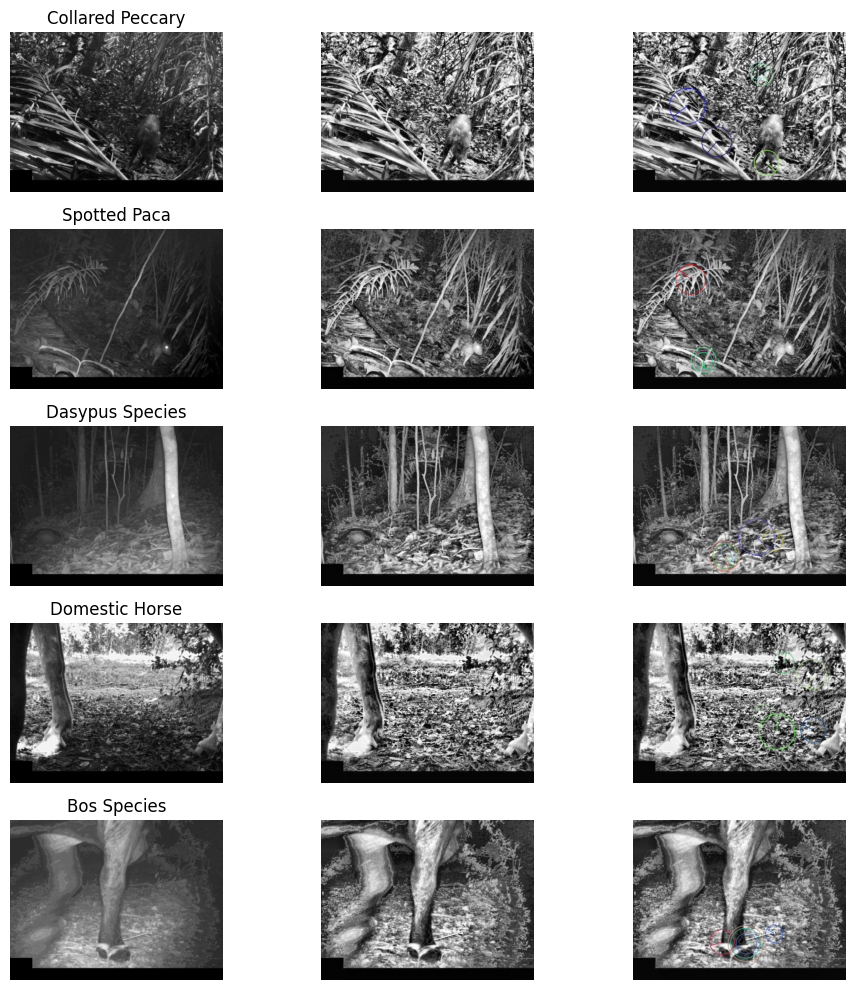

In [ ]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=3, figsize=(10, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  # img_raw = plt.imread(f"{downsampled_path}/{sample_filenames[i]}")
  # img_preprocessed = plt.imread(f"{preprocessed_path}/{sample_filenames[i]}")
  img_red = plt.imread(f"{preprocessed_red_path}/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.2, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)

  #ORB
  orb = cv2.ORB_create(nfeatures=5) #kind of works with smaller numners
  keypoints, descriptors = orb.detectAndCompute(img_cl, None)
  orb_img = cv2.drawKeypoints(img_cl, keypoints, img_cl, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  # preprocessed and resized
  axs[i, 0].imshow(img_resized, cmap='gray')
  axs[i, 0].set_title(species_list[i])
  axs[i, 0].axis("off")

  #histogram equalization (CLAHE)
  axs[i, 1].imshow(img_cl, cmap='gray')
  axs[i, 1].axis("off")

  #SIFT
  axs[i, 2].imshow(orb_img, cmap='gray')
  axs[i, 2].axis("off")

plt.show()